# Importing packages and reading in data

In [1]:
#import xgboost as xgb
import pandas as pd
import numpy as np
from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

#train_tgt = pd.read_csv("Data/Train_data_tgt.csv") 
#train_tgt = train_tgt.drop(columns = ['Unnamed: 0'])
#test_tgt = pd.read_csv("Data/Test_data_tgt.csv")
#test_tgt = test_tgt.drop(columns = ['Unnamed: 0'])
#train_sep = pd.read_csv("Data/Train_data_sep.csv")
#train_sep = train_sep.drop(columns = ['Unnamed: 0'])
#test_sep = pd.read_csv("Data/Test_data_sep.csv")
#test_sep = test_sep.drop(columns = ['Unnamed: 0'])

# Class imbalance functions

In [2]:
def random_undersample(train_data):
    train_data = train_data.drop(columns = ["gene_id","Transcript_ID","Base_seq"])
    negative_class = train_data[train_data['label'] == 0]
    positive_class = train_data[train_data['label'] == 1]
    sampled_majority_class = negative_class.sample(n=len(positive_class), random_state=45)
    output = pd.concat([sampled_majority_class, positive_class],axis = 0,ignore_index = True)
    return output

def GANsampling(train_data,no_of_samples = 50000):
    data = train_data.drop(columns = ["gene_id","Transcript_ID","Base_seq"])
    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(data=data)
    metadata.update_column("label",sdtype="categorical")
    CTGAN = CTGANSynthesizer(
        metadata, 
        enforce_rounding=False,
        epochs=50,
        verbose=False
    )
    CTGAN.fit(data)
    CT_samples = CTGAN.sample(num_rows=no_of_samples)
    New_positive = CT_samples[CT_samples["label"] == 1]
    output = pd.concat([data,New_positive],axis = 0, ignore_index = True) 
    return output

def adasyn_sample(train):
    X = train.drop(columns = ["label","gene_id","Transcript_ID","Base_seq"])
    y = train['label']
    adasyn_model = ADASYN(sampling_strategy='auto', random_state=42)
    X_adasyn_sample, y_adasyn_sample = adasyn_model.fit_resample(X, y)
    output = pd.concat([X_adasyn_sample, y_adasyn_sample], axis=1)
    return output

# Principal Components with mean and std together

### Random Undersample

In [3]:
from sklearn.linear_model import LogisticRegression
new_train_data = random_undersample(train_tgt)
X_train = new_train_data.drop('label', axis=1)
Y_train = new_train_data['label']
X_test = test_tgt.drop(columns = ["label","gene_id","Transcript_ID","Base_seq"],axis = 1)
Y_test = test_tgt['label']

model = LogisticRegression()

model.fit(X_train, Y_train)

Y_pred = model.predict_proba(X_test)[:, 1]

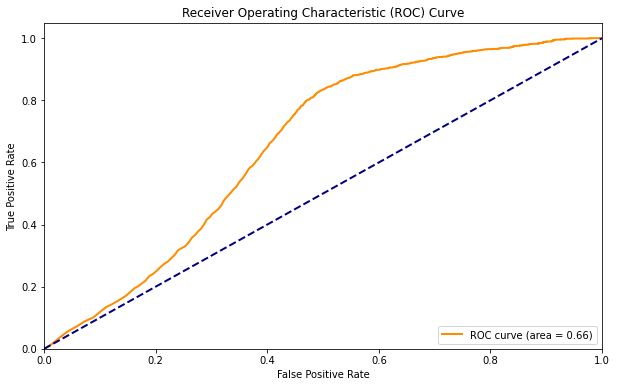

In [4]:
fpr, tpr, _ = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)
#accuracy = accuracy_score(Y_test, Y_pred)
#print(f'Accuracy: {accuracy * 100:.2f}%')
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
#plt.show()

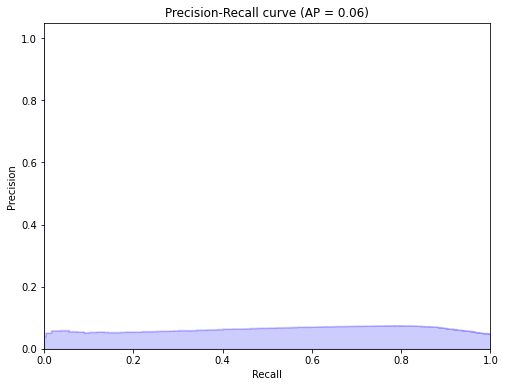

In [5]:
precision, recall, thresholds = precision_recall_curve(Y_test, Y_pred)

# Calculate the average precision score
average_precision = average_precision_score(Y_test, Y_pred)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()

### GAN sampling

In [7]:
new_train_data = GANsampling(train_tgt)
X_train = new_train_data.drop('label', axis=1)
Y_train = new_train_data['label']
X_test = test_tgt.drop(columns = ["label","gene_id","Transcript_ID","Base_seq"],axis = 1)
Y_test = test_tgt['label']

model = LogisticRegression()

model.fit(X_train, Y_train)

Y_pred = model.predict_proba(X_test)[:, 1]

KeyboardInterrupt: 

### Adasyn

In [8]:
new_train_data = adasyn_sample(train_tgt)
X_train = new_train_data.drop('label', axis=1)
Y_train = new_train_data['label']
X_test = test_tgt.drop(columns = ["label","gene_id","Transcript_ID","Base_seq"],axis = 1)
Y_test = test_tgt['label']

model = LogisticRegression()

model.fit(X_train, Y_train)

Y_pred = model.predict_proba(X_test)[:, 1]

/Users/tanjunheng/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


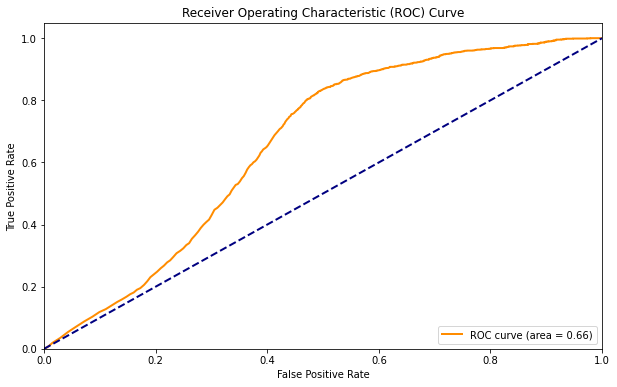

In [9]:
fpr, tpr, _ = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)
#accuracy = accuracy_score(Y_test, Y_pred)
#print(f'Accuracy: {accuracy * 100:.2f}%')
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
#plt.show()

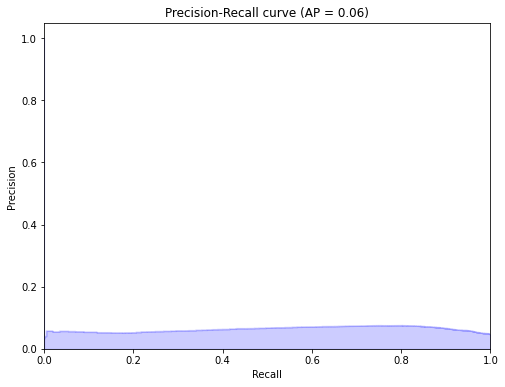

In [10]:
precision, recall, thresholds = precision_recall_curve(Y_test, Y_pred)

# Calculate the average precision score
average_precision = average_precision_score(Y_test, Y_pred)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()

# Principal Components with mean and std separate

### Random Undersample

In [11]:
new_train_data = random_undersample(train_sep)
X_train = new_train_data.drop('label', axis=1)
Y_train = new_train_data['label']
X_test = test_sep.drop(columns = ["label","gene_id","Transcript_ID","Base_seq"],axis = 1)
Y_test = test_sep['label']

model = LogisticRegression()

model.fit(X_train, Y_train)

Y_pred = model.predict_proba(X_test)[:, 1]

/Users/tanjunheng/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


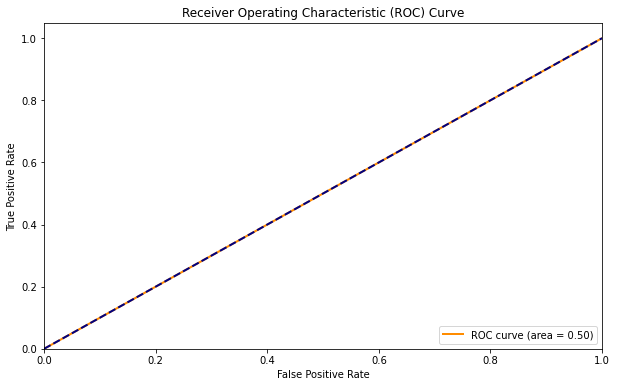

In [12]:
fpr, tpr, _ = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)
#accuracy = accuracy_score(Y_test, Y_pred)
#print(f'Accuracy: {accuracy * 100:.2f}%')
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

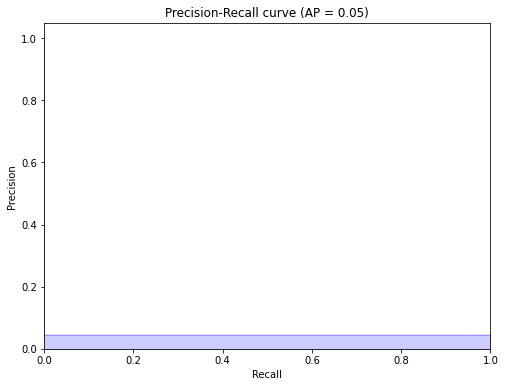

In [13]:
precision, recall, thresholds = precision_recall_curve(Y_test, Y_pred)

# Calculate the average precision score
average_precision = average_precision_score(Y_test, Y_pred)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()

### GAN sampling

In [14]:
new_train_data = GANsampling(train_sep)
X_train = new_train_data.drop('label', axis=1)
Y_train = new_train_data['label']
X_test = test_tgt.drop(columns = ["label","gene_id","Transcript_ID","Base_seq"],axis = 1)
Y_test = test_tgt['label']

model = LogisticRegression()

model.fit(X_train, Y_train)

Y_pred = model.predict_proba(X_test)[:, 1]

KeyboardInterrupt: 

### Adasyn

In [15]:
new_train_data = adasyn_sample(train_sep)
X_train = new_train_data.drop('label', axis=1)
Y_train = new_train_data['label']
X_test = test_sep.drop(columns = ["label","gene_id","Transcript_ID","Base_seq"],axis = 1)
Y_test = test_sep['label']

model = LogisticRegression()
model.fit(X_train, Y_train)

Y_pred = model.predict_proba(X_test)[:, 1]

/Users/tanjunheng/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


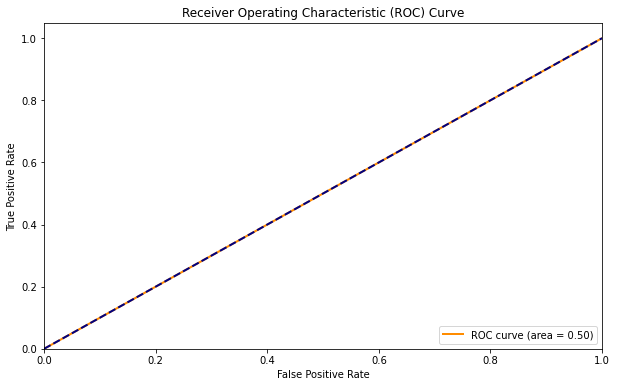

In [16]:
fpr, tpr, _ = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)
#accuracy = accuracy_score(Y_test, Y_pred)
#print(f'Accuracy: {accuracy * 100:.2f}%')
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

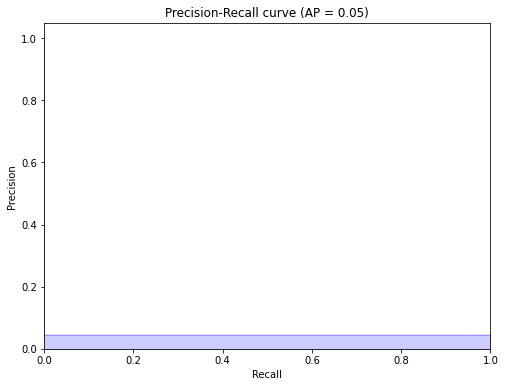

In [17]:
precision, recall, thresholds = precision_recall_curve(Y_test, Y_pred)

# Calculate the average precision score
average_precision = average_precision_score(Y_test, Y_pred)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()

In [ ]:
train_data = pd.read_csv("data")